# 4. 数据计算与统计试题

4.1计算股票600104与600518的相关系数、spearman排序相关性与30天滚动的五日收益协方差

In [1]:
import pandas as pd
stock1 = pd.read_excel('sz50.xlsx',sheetname = '600104.XSHG',index_col = 'datetime')
stock2 = pd.read_excel('sz50.xlsx',sheetname = '600518.XSHG',index_col = 'datetime')
df_5day = pd.concat([stock1.close.pct_change(5),stock2.close.pct_change(5)],keys = ['stock1','stock2'],axis = 1)

In [2]:
corr = df_5day.corr()
print(corr)

          stock1    stock2
stock1  1.000000  0.348809
stock2  0.348809  1.000000


In [3]:
corr_spearman = df_5day.corr(method = 'spearman')
print(corr_spearman)

         stock1   stock2
stock1  1.00000  0.38035
stock2  0.38035  1.00000


In [4]:
cov_roll30 = df_5day.rolling(30).cov()
print(cov_roll30.tail(6))

                              stock1    stock2
datetime                                      
2017-11-16 15:00:00 stock1  0.001200  0.000289
                    stock2  0.000289  0.000682
2017-11-17 15:00:00 stock1  0.001196  0.000291
                    stock2  0.000291  0.000710
2017-11-20 15:00:00 stock1  0.001192  0.000318
                    stock2  0.000318  0.000696


4.2
读取600104.XSHG的股票日线

利用正确的方法将日K线聚合成周K线

将周K线画出来

In [5]:
stock1_1 = stock1.resample('W').agg({'high':'max','low':'min', 'close':'last', 'open':'first'})

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


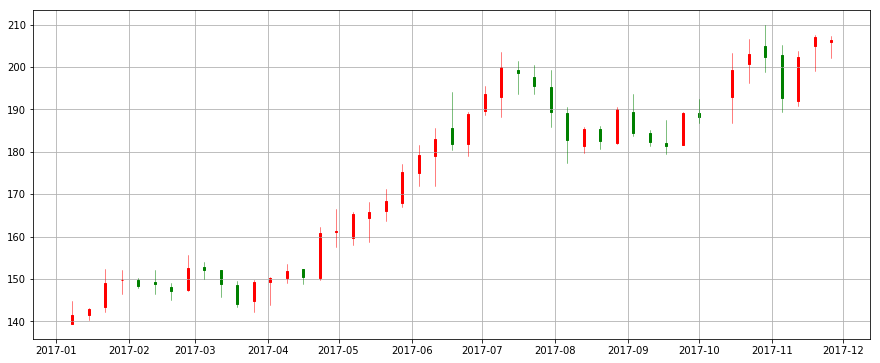

In [6]:
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
%matplotlib inline

stock1_1['time'] = list(map(date2num, stock1_1.index))
candle = stock1_1.reindex_axis(["time", "open", "high", "low", "close"], 1).values


fig, (ax) = plt.subplots(1,1, figsize=(15,12))
fig.subplots_adjust(bottom=0.5)
ax.grid(True)
mpf.candlestick_ohlc(ax, candle, width=0.8, colorup='r', colordown='g',alpha=1.0)
ax.xaxis_date ()
plt.show()

4.3 读取股票601857数据，计算股票回报率，判断样本在2017-01-01,到2017-12-31，有没有服从正态分布，并判断样本均值是否为0

In [7]:
from statsmodels.stats.stattools import jarque_bera
stock3 = pd.read_excel('sz50.xlsx',sheetname = '601857.XSHG',index_col = 'datetime')
stock3['return_pct'] = stock3['close'].pct_change()
return_pct = stock3['return_pct'][1:]
_, pvalue, _, _ = jarque_bera(return_pct)
if pvalue > 0.05:
    print ('判断样本分布服从正态分布')
else:
    print ('判断样本分布不服从正态分布')

判断样本分布不服从正态分布


In [8]:
from scipy import stats
t_test = stats.ttest_1samp(return_pct, 0)
if t_test.pvalue > 0.05:
    print ('判断样本均值为0')
else:
    print ('判断样本均值不为0')

判断样本均值为0


4.4 用Pandas的递归函数计算EMA与DEMA，对比talib的EMA与DEMA
1. 根据以上的算法，利用Pandas的ewm方法计算601901.XSHG以10天为周期的EMA，再算出DEMA。
2. 用talib计算601901.XSHG以10天为周期的EMA，再算出DEMA。
3. 打印两个结果的最后5个数据

In [9]:
import pandas as pd
stock4 = pd.read_excel('sz50.xlsx',sheetname = '601901.XSHG',index_col = 'datetime')
ema = stock4['close'].ewm(span = 10).mean()
dema = 2*ema - ema.ewm(span = 10).mean()
print(dema.tail(5))

datetime
2017-11-14 15:00:00    8.602581
2017-11-15 15:00:00    8.572151
2017-11-16 15:00:00    8.479642
2017-11-17 15:00:00    8.354917
2017-11-20 15:00:00    8.299691
Name: close, dtype: float64


In [10]:
import talib as ta
ema = pd.DataFrame({'ema':ta.EMA(stock4.close.values,10)},index=stock4.index)
dema = pd.DataFrame({'dema':ta.DEMA(stock4.close.values,10)},index=stock4.index)
print(dema['dema'][-5:])

datetime
2017-11-14 15:00:00    8.602581
2017-11-15 15:00:00    8.572151
2017-11-16 15:00:00    8.479642
2017-11-17 15:00:00    8.354917
2017-11-20 15:00:00    8.299691
Name: dema, dtype: float64


# 5.分析工具

数据时间：  'start_date': 20140101, 'end_date': 20180101, '

5.1 用alphalens分析沪深300成分股里float_mv因子在5日、30日、60日持有期下的因子表现。 （要求：按上证交易所上市、深证交易所上市分组，绘制ic柱状图比较不同组在不同持有期下的ic差异）-最后结果输出类似下面的表和图。

In [1]:
from jaqs_fxdayu.data import DataView # 可以视为一个轻量级的数据库，数据格式基于pandas，方便数据的调用和处理
from jaqs_fxdayu.data import RemoteDataService # 数据服务，用于下载数据
import os
import warnings
from datetime import datetime
import alphalens

C:\ProgramData\Anaconda3\lib\importlib\__init__.py:126: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return _bootstrap._gcd_import(name[level:], package, level)


In [2]:
warnings.filterwarnings("ignore")
dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [4]:
import pandas as pd
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index)) 
    return df

factor = change_index(dv.get_ts('float_mv')).stack()
prices = change_index(dv.get_ts('close_adj'))
group = dv.get_ts('close_adj')
for stock in group.columns:
    group[stock] = stock[-2:]
group = change_index(group)

In [5]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor,
                                                                   prices,
                                                                   groupby=group.stack(),
                                                                   quantiles=10,
                                                                   periods=(5, 30, 60))
ic_by_group = alphalens.performance.mean_information_coefficient(factor_data, by_group=True)
ic_by_group.head()

Dropped 6.4% entries from factor data (6.4% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


,5,30,60
group,,,
,NaN,NaN,NaN
SH,-0.019890,-0.011939,0.004947
SZ,-0.031756,-0.049609,-0.058176


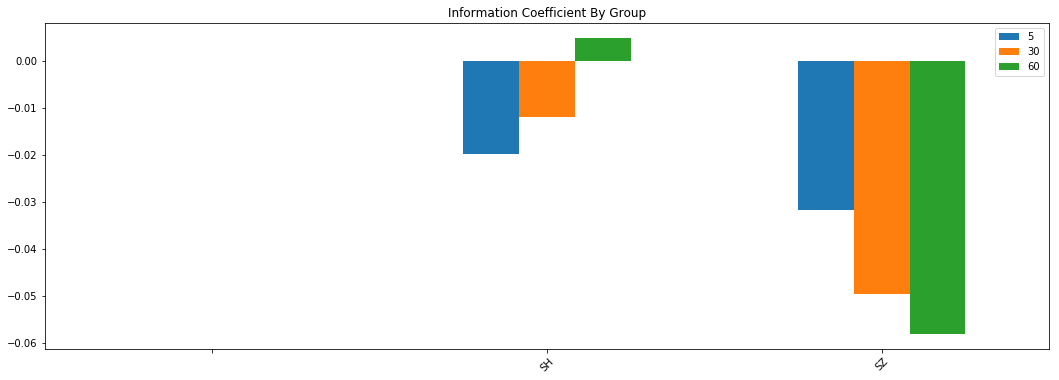

In [6]:
from matplotlib import pyplot as plt

alphalens.plotting.plot_ic_by_group(ic_by_group)
plt.show()

5.2（大致输出结果有下图）

5.2.1可视化比较CCI、Divert（习题定义）、pb的10日变化率、vwap_adj的10日变化率 这4个因子在5日、30日、60日持有期下的平均IC和IC_IR

5.2.2挑选上题中5日IC_IR最大的3个因子进行因子组合（注意需对因子进行去极值和z-score标准化处理，最终的组合因子也需要进行z-score标准化处理），并用柱状图比较各组合方法生成的因子与原因子在5日持有期下的IC和IC_IR；调用指标分析和可视化分析的方法，查看ic_weight方法合成的因子绩效，保存该合成方法下绩效最好quantile的选股结果

Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%


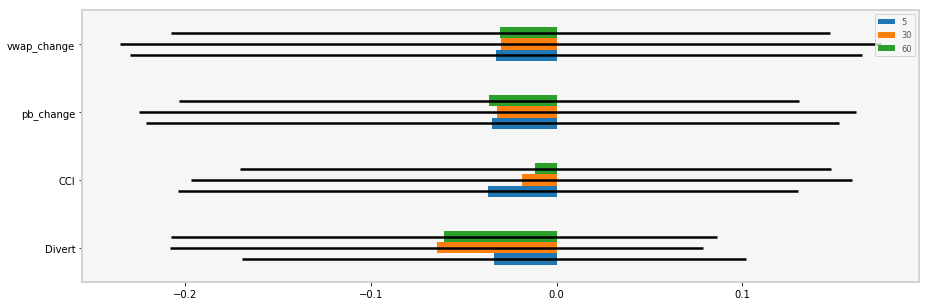

In [7]:
import numpy as np
from jaqs_fxdayu.research.signaldigger import process
from jaqs_fxdayu.research.signaldigger import multi_factor


High = dv.get_ts("high_adj")
Low = dv.get_ts("low_adj")
Close = dv.get_ts("close_adj")
trade_status = dv.get_ts('trade_status')
mask_sus = trade_status == 0
high_masked = process._mask_df(High,mask=mask_sus)
low_masked = process._mask_df(Low,mask=mask_sus)
close_masked = process._mask_df(Close,mask=mask_sus)


from jaqs_fxdayu.data import signal_function_mod as sfm
CCI = sfm.ta(ta_method='CCI',
             ta_column=0, 
             High=high_masked, 
             Low=low_masked, 
             Close=close_masked,
             Volume=None,
             timeperiod=10)
dv.append_df(CCI,'CCI')
dv.add_formula("Divert", "Correlation(close_adj,volume,20)", is_quarterly=False,add_data=True)
dv.add_formula("pb_change", "Return(pb, 10)", is_quarterly=False,add_data=True)
dv.add_formula("vwap_change", "Return(vwap_adj, 10)", is_quarterly=False,add_data=True)


def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = ~(df_index_member >0) 
    return mask_index_member

def limit_up_down():
    
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == 0
    
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False, add_data=True)
    
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False, add_data=True)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) 
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) 
    return can_enter,can_exit

mask = mask_index_member()
can_enter,can_exit = limit_up_down()


ic = dict()
factors_dict = {signal:dv.get_ts(signal) for signal in ["Divert","CCI","pb_change","vwap_change"]}
for period in [5, 30, 60]:
    ic[period]=multi_factor.get_factors_ic_df(factors_dict,
                                              price=dv.get_ts("close_adj"),
                                              high=dv.get_ts("high_adj"), 
                                              low=dv.get_ts("low_adj"),
                                              n_quantiles=5,
                                              mask=mask,
                                              can_enter=can_enter,
                                              can_exit=can_exit,
                                              period=period,
                                              benchmark_price=dv.data_benchmark, 
                                              commission = 0.0008,
                                              )
ic_mean_table = pd.DataFrame(data=np.nan,columns=[5,30,60],index=["Divert","CCI","pb_change","vwap_change"])
ic_std_table = pd.DataFrame(data=np.nan,columns=[5,30,60],index=["Divert","CCI","pb_change","vwap_change"])
ir_table = pd.DataFrame(data=np.nan,columns=[5,30,60],index=["Divert","CCI","pb_change","vwap_change"])

for signal in ["Divert","CCI","pb_change","vwap_change"]:
    for period in [5,30,60]:
        ic_mean_table.loc[signal,period]=ic[period][signal].mean()
        ic_std_table.loc[signal,period]=ic[period][signal].std()
        ir_table.loc[signal,period]=ic[period][signal].mean()/ic[period][signal].std()
        
        
%matplotlib inline
ic_mean_table.plot(kind="barh",xerr=ic_std_table,figsize=(15,5))

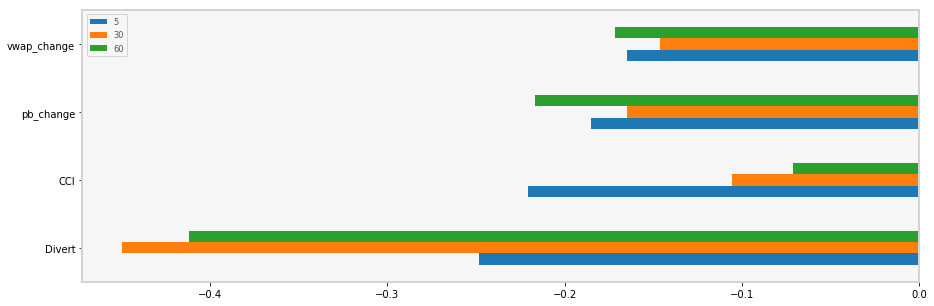

In [8]:
%matplotlib inline
ir_table.plot(kind="barh",figsize=(15,5))

### 比较组合前和组合后的因子在5日持有期下的表现（统一到2014年9月后进行比较）

Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective da

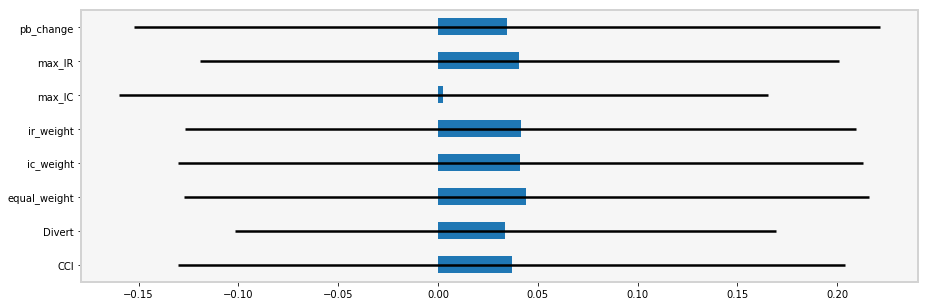

In [9]:
from jaqs_fxdayu.research.signaldigger import process
import datetime
import pandas as pd

factor_dict = dict()
index_member = dv.get_ts("index_member")
for name in ["CCI","pb_change","Divert"]:
    signal = -1*dv.get_ts(name) 
    process.winsorize(factor_df=signal,alpha=0.05,index_member=index_member)
    signal = process.standardize(signal,index_member)
    factor_dict[name] = signal
props = {
    'price':dv.get_ts("close_adj"),
    'high':dv.get_ts("high_adj"), 
    'low':dv.get_ts("low_adj"),
    'ret_type': 'return',
    'benchmark_price': dv.data_benchmark,  
    'period': 5, 
    'mask': mask,
    'can_enter': can_enter,
    'can_exit': can_exit,
    'forward': True,
    'commission': 0.0008,
    "covariance_type": "shrink",  
    "rollback_period": 120} 
comb_factors = dict()
for method in ["equal_weight","ic_weight","ir_weight","max_IR","max_IC"]:
    
    comb_factors[method] = multi_factor.combine_factors(factor_dict,
                                                        standardize_type="z_score",
                                                        winsorization=False,
                                                        weighted_method=method,
                                                        props=props)
    
period = 5
ic_5  =   multi_factor.get_factors_ic_df(comb_factors,
                                          price=dv.get_ts("close_adj"),
                                          high=dv.get_ts("high_adj"), 
                                          low=dv.get_ts("low_adj"),
                                          n_quantiles=5,
                                          mask=mask,
                                          can_enter=can_enter,
                                          can_exit=can_exit,
                                          period=period,
                                          benchmark_price=dv.data_benchmark,
                                          commission = 0.0008,
                                          )

ic_5 = pd.concat([ic_5,-1*ic[5].drop("vwap_change",axis=1)],axis=1)
ic_5_mean = dict()
ic_5_std = dict()
ir_5 = dict()
for name in ic_5.columns:    
    ic_5_mean[name]=ic_5[name].mean()
    ic_5_std[name]=ic_5[name].std()
    ir_5[name] = ic_5_mean[name]/ic_5_std[name]
    

trade_date = pd.Series(ic_5.index)
trade_date = trade_date.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
ic_5.index = trade_date

pd.Series(ic_5_mean).plot(kind="barh",xerr=pd.Series(ic_5_std),figsize=(15,5))

In [17]:
print(ic_5_mean['ir_weight'])
print(ic_5_mean['ic_weight'])
print(ic_5_mean['equal_weight'])

0.04137172522731763
0.041063026795019
0.044278379413196275


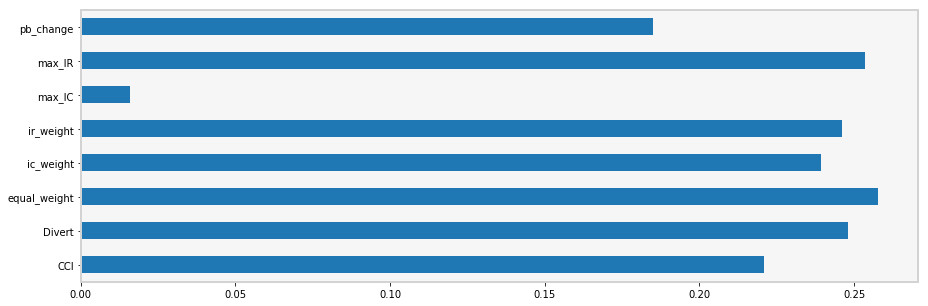

In [19]:
pd.Series(ir_5).plot(kind="barh",figsize=(15,5))

In [19]:
print(ir_5['ir_weight'])
print(ir_5['ic_weight'])
print(ir_5['equal_weight'])

0.24611193923474292
0.23929565394043223
0.2577392826231131


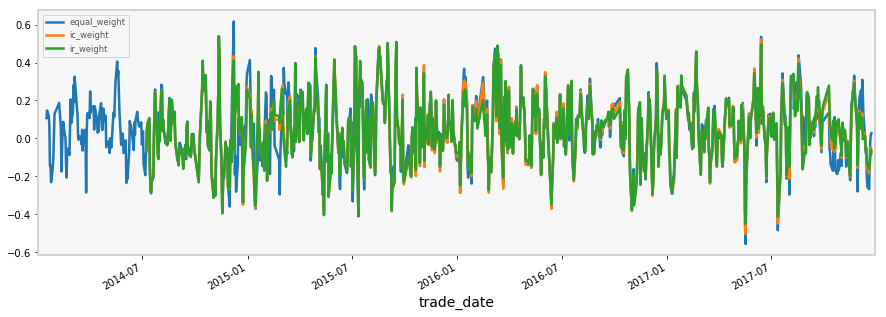

In [20]:
ic_5[["equal_weight","ic_weight","ir_weight"]].plot(kind="line",figsize=(15,5),)

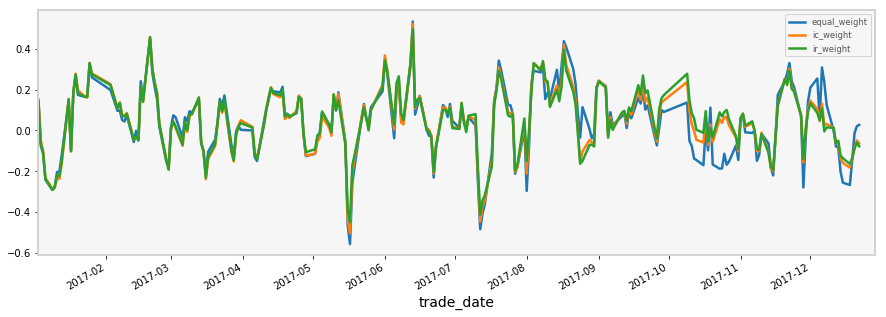

In [21]:
ic_5.loc[datetime.date(2017,1,3):,][["equal_weight","ic_weight","ir_weight"]].plot(kind="line",figsize=(15,5),)


5.3. 优化动量因子momentum：vwap_adj的n日变化率中的参数n（2<=n<=10）。优化目标是10日持有期的IC的IR。（要求：进行样本内优化，优化所用数据时段20140101~20170101，查看样本外20170101~表现，大致输出以下结果）

In [22]:
from jaqs_fxdayu.research import Optimizer
price = dv.get_ts('close_adj')
high = dv.get_ts('high_adj')
low = dv.get_ts('low_adj')
price_bench = dv.data_benchmark
optimizer = Optimizer(dataview=dv,
                      formula='- Return(vwap_adj,LEN)',
                      params={"LEN":range(2,11,1)},
                      name='momentum',
                      price=price,
                      high=high,
                      low=low,
                      benchmark_price=None,
                      period=10,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,
                      is_event=False,
                      is_quarterly=False)
ret_best = optimizer.enumerate_optimizer( 
                                         target_type="return_ic",
                                         target="Ann. IR",     
                                         in_sample_range=[20140101,20170101],
                                         ascending=False)

print(ret_best[0]["signal_name"])
print(ret_best[0]["ic"])
print(ret_best[0]["ret"])

print(ret_best[0]["space"])

Nan Data Count (should be zero) : 0;  Percentage of effective data: 58%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
momentum{'LEN': 10}
                return_ic  upside_ret_ic  downside_ret_ic
IC Mean      3.952566e-02      -0.036770     1.021542e-01
IC Std.      1.886946e-01       0.204269     1.879025e-01
t-stat(IC)   5.667287e+00      -4.870188     1.470886e+01
p-value(IC)  2.087785e-08       0.000001     4.321648e-43
IC Skew      2.214522e-01       0.578891  

样本外可视化



Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1        -0.808704  0.007599 -0.076528  0.050031  13750  20.129119
2        -0.084603  0.037019 -0.021038  0.018508  13677  20.022252
3        -0.050439  0.063253  0.001917  0.018536  13652  19.985653
4        -0.039393  0.098533  0.022451  0.022301  13677  20.022252
5        -0.020183  1.000000  0.064145  0.076642  13553  19.840724
Figure saved: E:\量化新兵\returns_report.pdf
Information Analysis
                ic
IC Mean     -0.025
IC Std.      0.198
t-stat(IC)  -1.889
p-value(IC)  0.060
IC Skew     -0.112
IC Kurtosis -0.640
Ann. IR     -0.123
Figure saved: E:\量化新兵\information_report.pdf


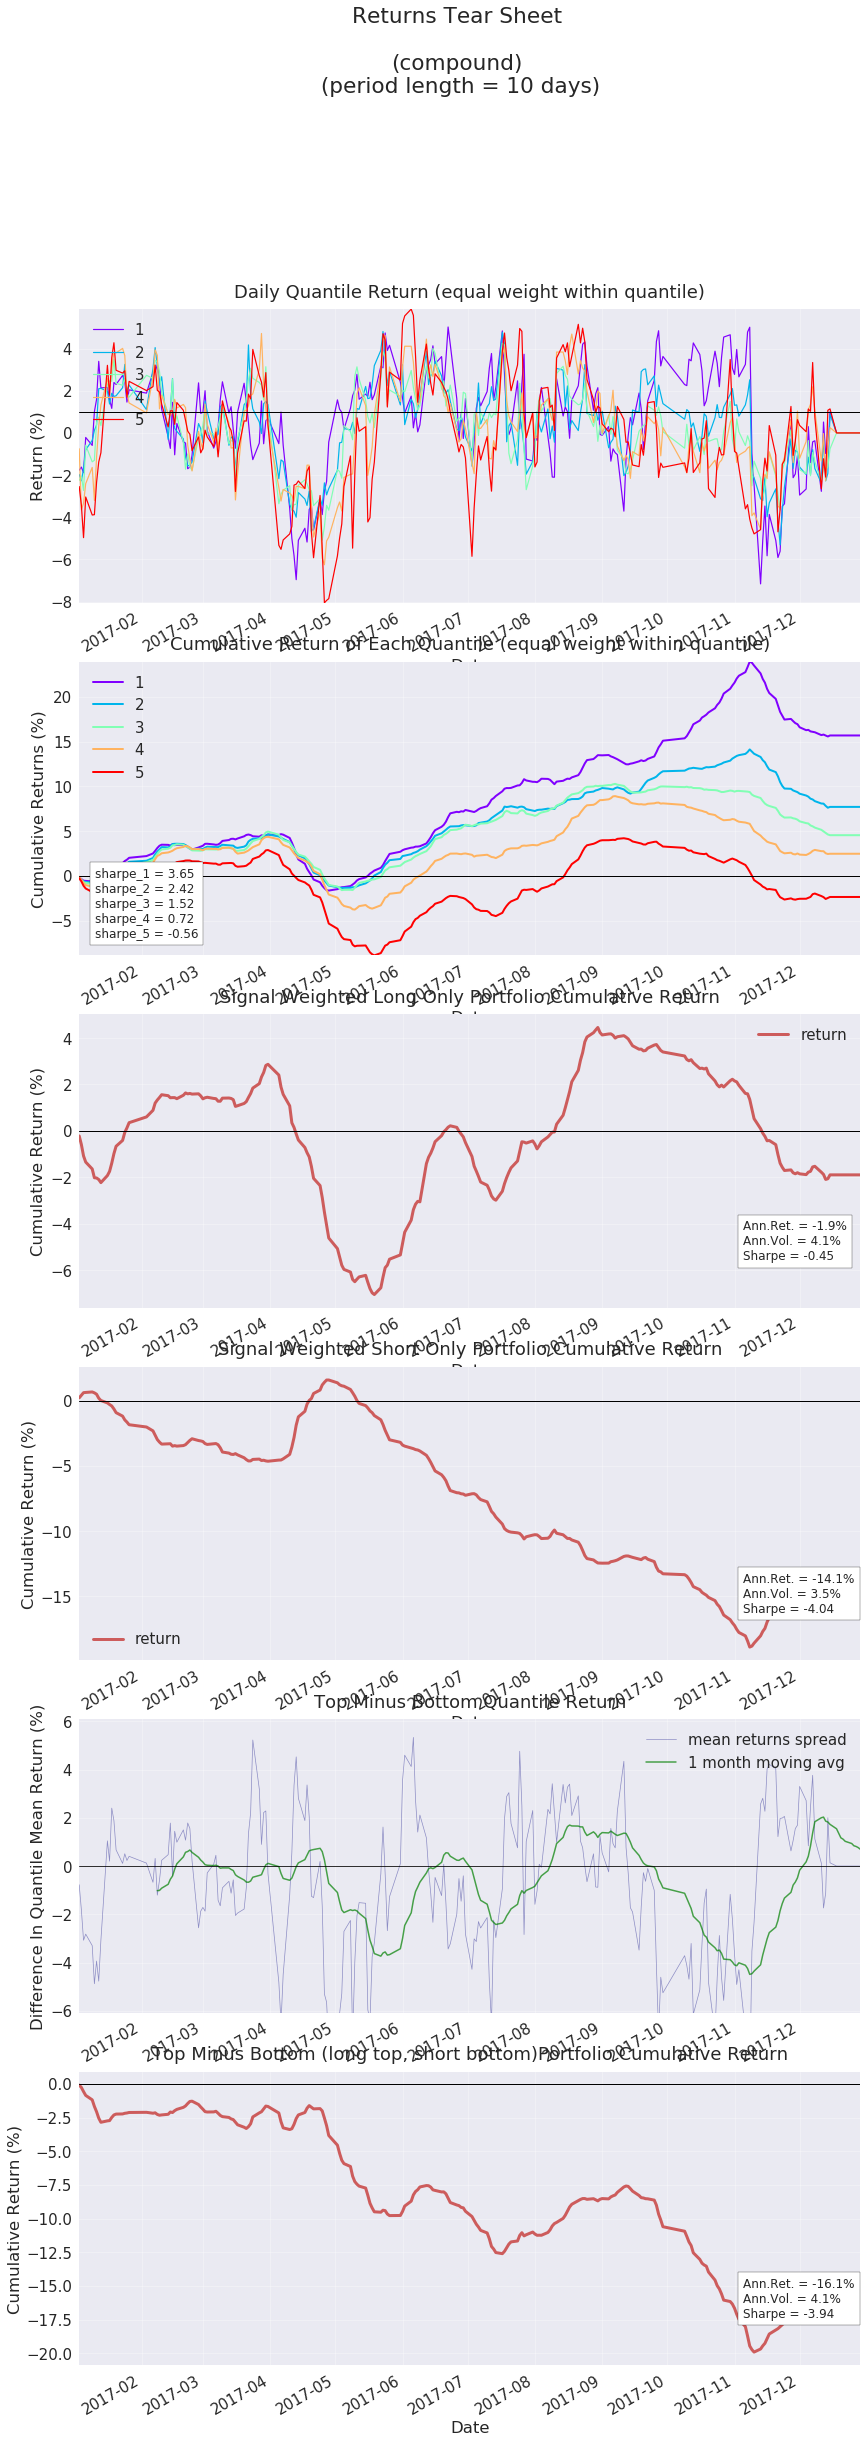

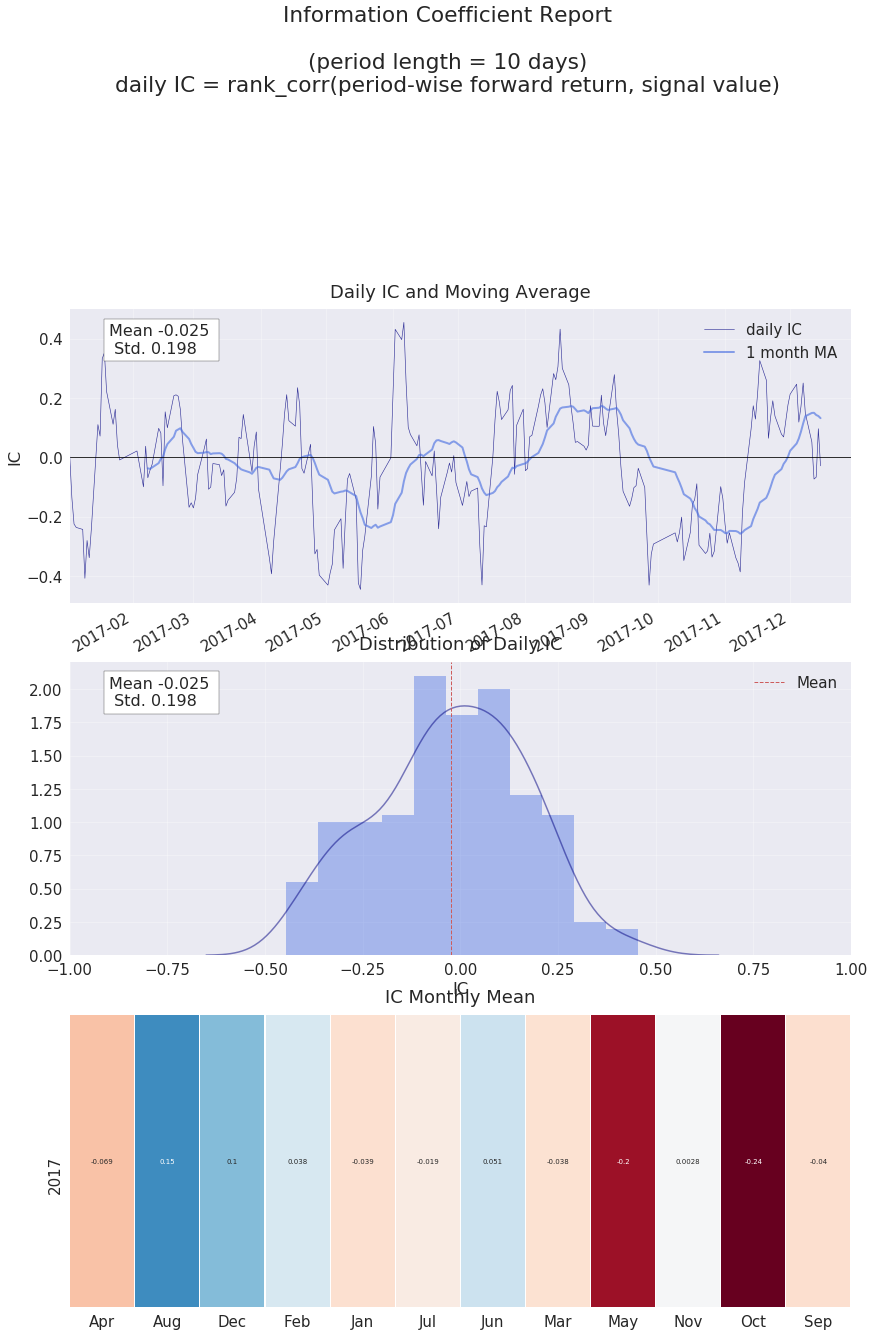

In [23]:
from jaqs_fxdayu.research import SignalDigger
from jaqs_fxdayu.research.signaldigger.analysis import analysis

import matplotlib.pyplot as plt
obj = SignalDigger()

def draw_analysis(signal_data,period):  
    obj.signal_data = signal_data
    obj.period = period
    obj.create_full_report()
    plt.show()
draw_analysis(optimizer.all_signals[ret_best[0]["signal_name"]].loc[20170101:], period=10)